In [1]:
import torch
import torch.nn as nn
import torchtext
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import ast
import time
from others.config import *

hyperparameters = config['hyperparameters']
gpu = ('cuda:0')

In [2]:
df = pd.read_csv('dataset/dataset_preprocessed_dws.csv')
df.head()

,Label,preprocessed_data
0,1,great day nt think group food averag buffet ok...
1,1,good star certainli star tower block hotel hou...
2,1,fade excel stop trip china great introduct hot...
3,2,love come busi meet use meet facil team wow sa...
4,1,pleasant vacat sister spent day resort juli ju...


In [3]:
df.tail()

,Label,preprocessed_data
6547,0,okay hotel commonwealth decent place conveni f...
6548,1,great locat ok w book hotel birthday celebr qu...
6549,2,perfect base book inn check review tripadvisor...
6550,0,overpr overr worn recommend hotel desk welcom ...
6551,1,better el san juan nice hotel definit lot offe...


In [4]:
print(f'Null Data: \n{df.isnull().sum()}\n')
print('Empty Cell: \n{}'.format(df[df['preprocessed_data'] == ''].index))

Null Data: 
Label                0
preprocessed_data    0
dtype: int64

Empty Cell: 
Int64Index([], dtype='int64')


In [5]:
print(len(df))

6552


(array([0, 1, 2]), [Text(0, 0, '2'), Text(1, 0, '1'), Text(2, 0, '0')])

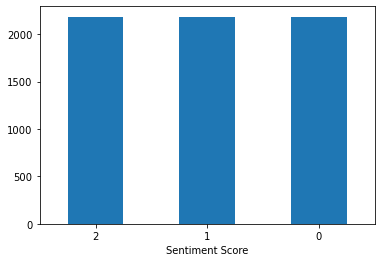

In [6]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment Score')
plt.xticks(rotation=0) 

In [7]:
TEXT = torchtext.data.Field(
    sequential = True,
    lower = True,
    batch_first = True,
    tokenize = 'spacy',
    pad_first = True
)

LABEL = torchtext.data.Field(
    sequential = False,
    use_vocab = False,
    is_target = True
)

In [8]:
dataset_ = torchtext.data.TabularDataset(
    path = 'dataset/dataset_preprocessed_dws.csv', 
    format = 'csv',
    skip_header = True,
    fields = [
        ('Label', LABEL),
        ('Review', TEXT) 
        ] 
)

In [9]:
print(dataset_[0].Review)
print(dataset_[0].Label)

['great', 'day', 'nt', 'think', 'group', 'food', 'averag', 'buffet', 'ok', 'regular', 'servic', 'restaur', 'averag', 'servic', 'good', 'bar', 'snack', 'bar', 'good', 'tip', 'help', 'room', 'nice', 'work', 'shade', 'beach', 'challleng', 'reserv', 'allow', 'creat', 'problem', 'gm', 'twice', 'unsu', 'hut', 'reclaim', 'user', 'pay', 'reserv', 'gynm', 'casino', 'joke', 'beer', 'cold', 'good', 'ca', 'nt', 'wrong', 'cold', 'president', 'beer', 'drink', 'barcelo', 'imperi', 'extra', 'brugal', 'good', 'tend', 'carter', 'european', 'saw', 'albita', 'cuban', 'night', 'great', 'mojito', 'good', 'summari', 'like', 'buffet', 'time', 'day', 'day']
1


In [10]:
doc_len = [len(dataset_[i].Review) for i in range(len(dataset_))]
longest_len = max(doc_len)
print('The longest doc in dataset is {} words, {} Sentiment Score, with idx {}'.format(longest_len, int(dataset_[doc_len.index(longest_len)].Label), doc_len.index(longest_len)))

The longest doc in dataset is 1861 words, 1 Sentiment Score, with idx 1052


In [11]:
# print('doc : {}'.format(dataset_[doc_len.index(longest_len)].Review))
print('label : {}'.format(dataset_[doc_len.index(longest_len)].Label))

label : 1


In [12]:
# why always shuffling ?
train_dataset, test_dataset = dataset_.split([0.7, 0.30], random_state = random.seed(14))

In [13]:
validation_dataset, test_dataset = test_dataset.split([0.25, 0.75], random_state = random.seed(14))

In [14]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(4586, 492, 1474)

In [15]:
TEXT.build_vocab(train_dataset)
vocab = TEXT.vocab
len(vocab)
# vocab.stoi

23878

In [16]:
train_iter, valid_iter = torchtext.data.BucketIterator.splits(
    (train_dataset, validation_dataset), 
    sort_key=lambda x: len(x.Review),
    batch_sizes=(ast.literal_eval(hyperparameters['batch_sizes'])[0], ast.literal_eval(hyperparameters['batch_sizes'])[1]), 
    device=gpu
    )

In [17]:
for inputs, labels in train_iter:
    print('inputs: {}, shape: {}'.format(inputs, inputs.shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

inputs: tensor([[   1,    1,    1,  ...,  114,  287,  395],
        [   1,    1,    1,  ...,  111,  870,  229],
        [   1,    1,    1,  ...,   71,    7,   17],
        ...,
        [   1,    1,    1,  ..., 1532,    5,    4],
        [   1,    1,    1,  ...,   40,  241,  137],
        [   1,    1,    1,  ...,   38,    2,    4]], device='cuda:0'), shape: torch.Size([64, 352])
lables: tensor([0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0,
        0, 0, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2], device='cuda:0'), shape: torch.Size([64])


In [18]:
for inputs, labels in valid_iter:
    print('inputs: {}, shape: {}'.format(inputs, inputs.shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

inputs: tensor([[  61,  564,    4,  ..., 1923,  457,    0],
        [   7,  546,   68,  ..., 2197,  132,    4],
        [   1,   12,    3,  ...,    6,   22,   25],
        ...,
        [   1,    1,    1,  ...,  606,   82, 4624],
        [   1,    1,    1,  ...,   58, 6221, 3425],
        [   1,    1,    1,  ...,    7, 2499,  740]], device='cuda:0'), shape: torch.Size([128, 52])
lables: tensor([2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 2, 0,
        2, 2, 0, 2, 2, 2, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 0,
        0, 1, 2, 2, 2, 0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 1, 2, 0,
        1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2,
        1, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 1,
        2, 2, 2, 1, 0, 1, 0, 0], device='cuda:0'), shape: torch.Size([128])


In [19]:
batch_train = next(iter(train_iter))
doc_train, label_train = batch_train
batch_test = next(iter(valid_iter))
doc_valid, label_valid = batch_test

def itos_(iterator):
    docs_ = []
    for i in range (len(iterator)):
        x = iterator[i].item()
        doc = str(TEXT.vocab.itos[x])
        docs_.append(doc)
    docs = ' '.join(docs_)
    return docs, docs_

In [20]:
# for accessing specific batch
every_batch = []
for batch in enumerate(train_iter):
    every_batch.append(batch)   
    # print(batch)
    # inputs, labels = batch.Review, batch.Label
    # print(inputs.shape, labels.shape)

In [21]:
print(itos_(doc_train[0])[0])
print('label: {}'.format(label_train[0]))

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [22]:
class BiLSTM(nn.Module):
    def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes):
        super(BiLSTM, self).__init__()
        self.v = n_vocabs
        self.e = embed_dims
        self.u = n_lstm_units
        self.l = n_lstm_layers
        self.o = n_output_classes

        self.embed = nn.Embedding(
            self.v,
            self.e
            )
        self.bilstm = nn.LSTM(
            input_size = self.e,
            hidden_size = self.u,
            num_layers = self.l,
            batch_first = True,
            bidirectional = True
        )
        self.linear = nn.Linear(
            self.u * 2,
            self.o
        )

    def forward(self, X):
        h0 = torch.zeros(self.l * 2, X.size(0), self.u).to(gpu)
        c0 = torch.zeros(self.l * 2, X.size(0), self.u).to(gpu)

        out = self.embed(X)
        # NxTxh, lxNxh
        out, _ = self.bilstm(out, (h0, c0))
        # GMP
        out, _ = torch.max(out, 1)
        out = self.linear(out)
        iout = torch.max(out, 1)[1]

        return iout, out

In [23]:
model = BiLSTM(
    len(vocab), 
    ast.literal_eval(hyperparameters['embed_dims']), 
    ast.literal_eval(hyperparameters['num_lstm_units']), 
    ast.literal_eval(hyperparameters['num_lstm_layers']), 
    ast.literal_eval(hyperparameters['num_output_classes'])
    ).to(gpu)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = ast.literal_eval(hyperparameters['learning_rate'])
    )
print(model)

BiLSTM(
  (embed): Embedding(23878, 128)
  (bilstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)


In [24]:
import sys
num_epochs = ast.literal_eval(hyperparameters['num_epochs'])
losses = []
accuracies  = []
val_losses = []
val_accuracies = []
val_loss_min = np.inf

for epoch in range(num_epochs):
    print('------------------------------------------------------------------------------------------')
    print('epoch: {}/{}:'.format(epoch + 1, num_epochs))   
    print('------------------------------------------------------------------------------------------')
    t0 = time.time()
    # ????
    train_tqdm_bar = tqdm(enumerate(train_iter), total = (len(train_iter)), leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    val_tqdm_bar = tqdm(enumerate(valid_iter), total = (len(valid_iter)),  leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    # ????
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for idx, (reviews, labels) in train_tqdm_bar:
        iout, out = model(reviews)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = 1)
        optimizer.step()
        running_loss += loss
        running_corrects += torch.sum(iout == labels)
        train_tqdm_bar.set_description(desc = 'train   '.format(epoch + 1, num_epochs))
        batch_idx = (idx + 1) * eval(hyperparameters['batch_sizes'])[0]
        train_tqdm_bar.set_postfix(
            loss = running_loss.item() / batch_idx if idx + 1 < len(train_iter) else running_loss.item() / len(train_iter.dataset)
            ,acc = running_corrects.item() / batch_idx if idx + 1 < len(train_iter) else running_corrects.item() / len(train_iter.dataset)
            )
    
    model.eval()
    with torch.no_grad():
        for val_idx, (v_reviews, v_labels) in val_tqdm_bar:
            v_iout, v_out = model(v_reviews)
            v_loss = criterion(v_out, v_labels)
            val_running_loss += v_loss
            val_running_corrects += torch.sum(v_iout == v_labels)
            val_tqdm_bar.set_description('validate'.format(epoch + 1, num_epochs))
            val_batch_idx = (val_idx + 1) * eval(hyperparameters['batch_sizes'])[1]
            val_tqdm_bar.set_postfix(
            val_loss = val_running_loss.item() / val_batch_idx if val_idx + 1 < len(valid_iter) else val_running_loss.item() / len(valid_iter.dataset)
            ,val_acc = val_running_corrects.item() / val_batch_idx if val_idx + 1 < len(valid_iter) else val_running_corrects.item() / len(valid_iter.dataset)
            )
    
    epoch_loss = running_loss/len(train_iter.dataset)
    losses.append(epoch_loss)
    epoch_accuracy = running_corrects/len(train_iter.dataset)
    accuracies.append(epoch_accuracy)
    val_epoch_loss = val_running_loss/len(valid_iter.dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_accuracy = val_running_corrects/len(valid_iter.dataset)
    val_accuracies.append(val_epoch_accuracy)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
        }
    
    print('training loss: {:.4f}, acc: {:.2f}'.format(epoch_loss, epoch_accuracy))
    print('validation loss: {:.4f}, acc: {:.2f}'.format(val_epoch_loss, val_epoch_accuracy))
    print('epoch time: {:.2f} seconds'.format(time.time() - t0))

    if val_epoch_loss <= val_loss_min:
        print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
        torch.save(checkpoint, r'checkpoint\\hotel_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
        val_loss_min = val_epoch_loss

------------------------------------------------------------------------------------------
epoch: 1/20:
------------------------------------------------------------------------------------------
training loss: 0.0136, acc: 0.58
validation loss: 0.0053, acc: 0.72
epoch time: 9.05 seconds
validation loss decreased from inf to 0.0053, saving model...
------------------------------------------------------------------------------------------
epoch: 2/20:
------------------------------------------------------------------------------------------
training loss: 0.0072, acc: 0.81
validation loss: 0.0051, acc: 0.74
epoch time: 8.82 seconds
validation loss decreased from 0.0053 to 0.0051, saving model...
------------------------------------------------------------------------------------------
epoch: 3/20:
------------------------------------------------------------------------------------------
training loss: 0.0030, acc: 0.93
validation loss: 0.0064, acc: 0.73
epoch time: 9.12 seconds
---------

KeyboardInterrupt: 